In [109]:
# !pip install --pre pycaret

In [110]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pycaret.regression import *
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV


sns.set_style("darkgrid")
%matplotlib inline

### Load data

In [111]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')
data = pd.concat([train_data, test_data], ignore_index=False, axis=0).reset_index(drop=True)
target = data['SalePrice']
data.drop(['Id', 'SalePrice'], axis=1, inplace=True)


## Data Cleaning

In [112]:
data['MSSubClass'] = data['MSSubClass'].astype('str')

In [113]:
clean_data = data.copy()

Clean numeric variables

In [114]:
clean_data.select_dtypes('object').isna().sum()[clean_data.select_dtypes('object').isna().sum()>0]

MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [115]:
for col in [
    'MasVnrType',
    'Electrical',
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'KitchenQual',
    'Functional',
    'SaleType'

]:
    clean_data[col] = clean_data[col].fillna(clean_data[col].mode()[0])

for col in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'

]:
    clean_data[col] = clean_data[col].fillna('None')

In [116]:
num_cols_to_impute = list(clean_data.select_dtypes(np.number).isna()\
.sum()[clean_data.select_dtypes(np.number).isna().sum()>0].index)


In [117]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
for col in num_cols_to_impute:
    clean_data[col] = imputer.fit_transform(clean_data[col].values.reshape(-1,1))

## Feature Enginering

In [118]:
# clean_data["SqFtPerRoom"] = clean_data["GrLivArea"] / (clean_data["TotRmsAbvGrd"]\
#                                                        +clean_data["FullBath"] +\
#                                                        clean_data["HalfBath"] + \
#                                                        clean_data["KitchenAbvGr"])

# clean_data['Total_Home_Quality'] = clean_data['OverallQual'] +\
#                                               clean_data['OverallCond']
# clean_data['Total_Bathrooms'] = (clean_data['FullBath'] +\
#                                  (0.5 * clean_data['HalfBath']) +\
#                                  clean_data['BsmtFullBath'] +\
#                                  (0.5 * clean_data['BsmtHalfBath']))

# clean_data["HighQualsF"] = clean_data["1stFlrSF"] + clean_data["2ndFlrSF"]

In [119]:
clean_data.select_dtypes(np.number).skew()

LotFrontage       1.646420
LotArea          12.829025
OverallQual       0.197212
OverallCond       0.570605
YearBuilt        -0.600114
YearRemodAdd     -0.451252
MasVnrArea        2.612892
BsmtFinSF1        1.425966
BsmtFinSF2        4.148166
BsmtUnfSF         0.919981
TotalBsmtSF       1.163082
1stFlrSF          1.470360
2ndFlrSF          0.862118
LowQualFinSF     12.094977
GrLivArea         1.270010
BsmtFullBath      0.624276
BsmtHalfBath      3.933365
FullBath          0.167692
HalfBath          0.694924
BedroomAbvGr      0.326492
KitchenAbvGr      4.304467
TotRmsAbvGrd      0.758757
Fireplaces        0.733872
GarageYrBlt      -0.392992
GarageCars       -0.218410
GarageArea        0.241342
WoodDeckSF        1.843380
OpenPorchSF       2.536417
EnclosedPorch     4.005950
3SsnPorch        11.381914
ScreenPorch       3.948723
PoolArea         16.907017
MiscVal          21.958480
MoSold            0.195985
YrSold            0.132467
dtype: float64

In [120]:
transformed_data = clean_data.copy()

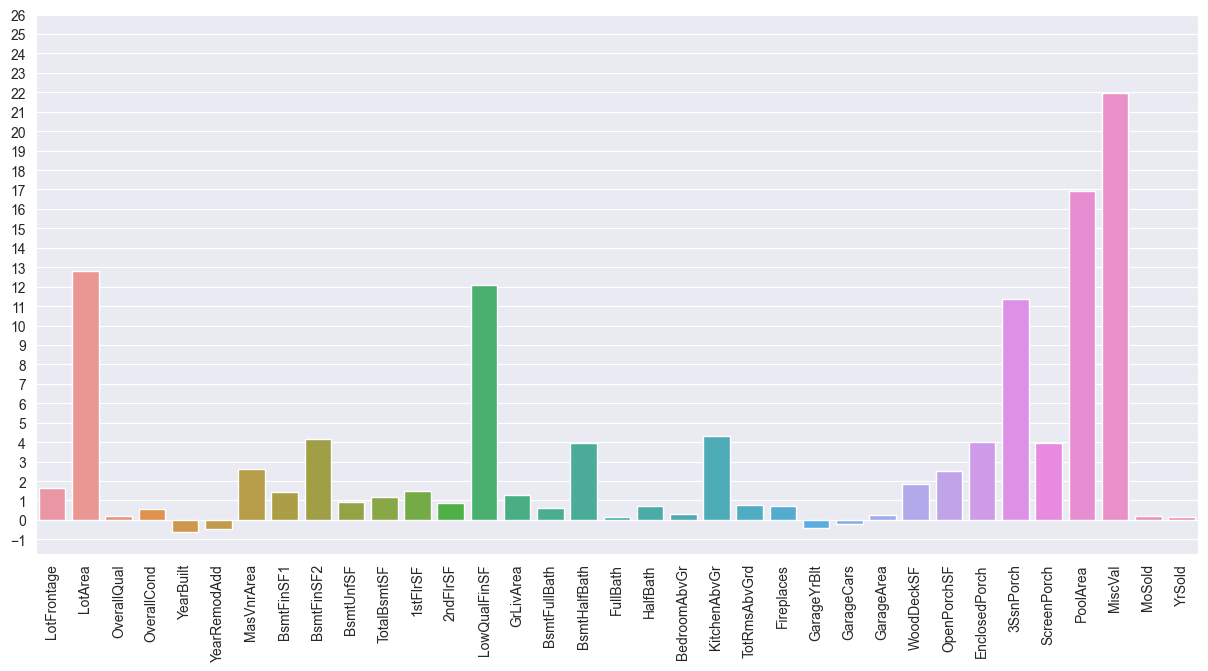

In [121]:
plt.figure(figsize=(15,7))
sns.barplot(x=transformed_data.select_dtypes(np.number).skew().index, y=transformed_data.select_dtypes(np.number).skew().values)
plt.xticks( rotation=90)
plt.yticks(np.arange(-1,27, 1))
plt.show()

## Log Trnasformation

In [122]:
    
lv3_trans = list(transformed_data.select_dtypes(np.number).skew()\
                [abs(transformed_data.select_dtypes(np.number).skew())>5].index)
for col in lv3_trans:
    transformed_data[col] = np.log(transformed_data[col] + 5)
    
    
lv4_trans = list(transformed_data.select_dtypes(np.number).skew()\
                [abs(transformed_data.select_dtypes(np.number).skew())>0.5].index)
for col in lv4_trans:
    transformed_data[col] = np.log1p(transformed_data[col])

## Encode categorical features:

In [123]:
data_encoded = pd.get_dummies(transformed_data)
data_encoded.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Fun

## Scaling

In [124]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_encoded), index=data_encoded.index, columns=data_encoded.columns)

In [125]:
target = target[:1459]
log1p_target = np.log1p(target)

## Separate train and test 

In [126]:
train_data.shape
train_final = data_scaled.iloc[:1459]
test_final = data_scaled.iloc[1460:].reset_index(drop=True)

## Model Selection

### Baseline model:

In [127]:
baseline_model = gbr = GradientBoostingRegressor()
baseline_model.fit(train_final, log1p_target)

GradientBoostingRegressor()

### Evaluate

In [128]:
kf = KFold(n_splits=10, shuffle=True)
results = cross_val_score(baseline_model, train_final, log1p_target, cv=kf, scoring='neg_mean_squared_error')

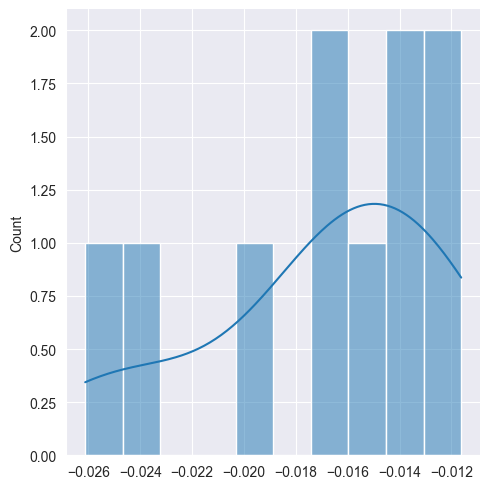

In [129]:
sns.displot(results, bins=10, kde=True)

In [130]:
np.exp(np.sqrt(np.mean(-results))) - 1

0.1393256568501533

### LazyPredict:

In [131]:
X_train, X_test, y_train, y_test = train_test_split(train_final, log1p_target, test_size=0.3, random_state=42)

In [132]:
models = {
    'catboost': CatBoostRegressor(verbose=0, depth=5, learning_rate=0.24576833071701198),
    'lgbm': LGBMRegressor(learning_rate= 0.1865223911123105,\
                          n_estimators= 295, num_leaves=15),
    'br': BayesianRidge(alpha_1=0.001, alpha_2=0.1, lambda_1=0.1, lambda_2=0.001),
    'ridge': Ridge(alpha= 100),
    'XGB': XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=300),
    'gbr': GradientBoostingRegressor(learning_rate=0.05, max_depth=3, n_estimators=300),
    'omp': OrthogonalMatchingPursuit(n_nonzero_coefs=20)
}


In [133]:
for name, model in models.items():
    model.fit(train_final, log1p_target)
    print(name, 'Trained')

catboost Trained
lgbm Trained
br Trained
ridge Trained
XGB Trained
gbr Trained
omp Trained


In [134]:
results = {}
for name, model in models.items():
    kf = KFold(n_splits=5, shuffle=False)
    result = cross_val_score(model, train_final, log1p_target, cv=kf, \
                              scoring='neg_mean_squared_error')
    print(name+ ' : mean= '+ str(-result.mean())+ ' std= '+ str(result.std()))
    results[name] = np.mean(-result)
    

catboost : mean= 0.01565338661482969 std= 0.0025643558779297844
lgbm : mean= 0.017632481107777386 std= 0.0019944010275939747
br : mean= 0.017984056591641293 std= 0.0043612810980879525
ridge : mean= 0.01776244274654637 std= 0.004232015203209545
XGB : mean= 0.01667841495397489 std= 0.0023973709958517516
gbr : mean= 0.015331642682134508 std= 0.002152650113992236
omp : mean= 0.019083781281143672 std= 0.0050451091666154965


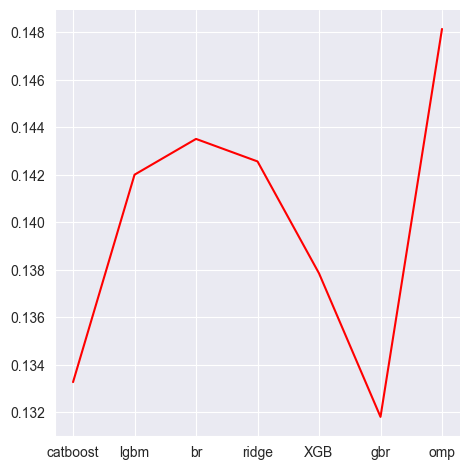

In [135]:
sns.relplot(x=results.keys(), y=np.exp(np.sqrt(list(results.values()))) - 1, kind='line', color='red')

## HyperParameter Optimization:

## Combine Predictions:

In [147]:
final_predictions = (
    2/7 * (np.exp(models['omp'].predict(test_final)) - 1) +\
    1/7 * (np.exp(models['gbr'].predict(test_final)) - 1) +\
    1/7 * (np.exp(models['br'].predict(test_final)) - 1) +\
    1/7 * (np.exp(models['lgbm'].predict(test_final)) - 1) + \
    1/7 * (np.exp(models['XGB'].predict(test_final)) - 1) + \
    1/7 * (np.exp(models['ridge'].predict(test_final)) - 1) 
    # 1/7 * (np.exp(models['catboost'].predict(test_final)) - 1)
    
)

In [148]:
submission = pd.concat([pd.Series(list(test_data.Id), name='Id'), \
           pd.Series(list(final_predictions), name='SalePrice')], axis=1)

In [149]:
submission.to_csv('submission.csv', header=True, index=False)

In [150]:
pd.read_csv('submission.csv')

,Id,SalePrice
0,1461,142672.318257
1,1462,181345.255514
2,1463,212252.173687
3,1464,224739.228968
4,1465,223760.962657
...,...,...
1454,2915,95703.402232
1455,2916,95402.166365
1456,2917,183507.050709
1457,2918,135917.286435
